# SETUP

## Check environment

In [1]:
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f"Using Google Colab: {COLAB}")

Using Google Colab: False


In [2]:
!pip install --upgrade pip tensorflow keras scikit-learn &> pip.log
!pip install openpyxl pydot >> pip.log
!apt-get install graphviz -y &> apt.log
!pip install 'tensorflow[and-cuda]' >> pip.log

if not COLAB:
    !pip install jupyterlab-vim jupyterlab-indent-guides >> pip.log

## Libraries

In [3]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
if COLAB:
    sys.path.append("/content/air_quality_index_project")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import predictLSTM, evaluateLSTM, predictLSTMNoSplit
from src.time_series_utils import prepareReducedData

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1752049903.259819  636939 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752049903.266237  636939 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752049903.282629  636939 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752049903.282651  636939 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752049903.282653  636939 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752049903.282654  636939 computation_placer.cc:177] computation placer already registered. Please check linka

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [4]:
if COLAB:
    confReader = ConfigurationReader("/content/air_quality_index_project/model_params.json")
else:
    confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data
print(conf)

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["model_info_dir"])
cleanDir(conf["workspace"]["model_checkpoints_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])

{
    "dataset": {
        "aod2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx"
        },
        "aod2021": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31"
        }
    },
    "workspace": {
        "model_info_dir": "/le_thanh_van_118/workspace/hiep_workspace/model_info",
        "model_checkpoints_dir": "/le_thanh_van_118/workspace/hiep_workspace/model_checkpoints",
        "data_by_location_dir": "/le_thanh_van_118/workspace/hiep_workspace/data_by_location",
        "data_by_station_dir": "/le_thanh_v

# AOD DATA

## Load 2022 dataset

In [5]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


,time,ID,pm25,lat,lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,Name
0,2022-01-01,S4,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
1,2022-01-01,S5,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,...,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568,Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3
2,2022-01-01,S6,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
3,2022-01-01,S7,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
4,2022-01-02,S4,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,2022-12-30,S6,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"
994,2022-12-30,S7,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,...,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924,ĐSQ Mỹ
995,2022-12-31,S4,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,...,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486,"Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn..."
996,2022-12-31,S6,28.854069,10.780482,106.659511,27.658358,25.364861,62.377899,799.122803,4.161542,...,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348,"MobiFone Thành Thái, Q10"


In [6]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pres2m,aod,...,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01,23.768238,10.815839,106.717396,22.025597,28.261583,57.233841,721.996887,2.003031,101227.000000,0.338000,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
2022-01-01,14.221014,10.776415,106.687955,22.705284,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,...,23.362053,7249.776367,21.703104,395.082094,877872.4121,0.00000,98.770523,121487.74380,0.00000,1721.431568
2022-01-01,21.405015,10.780482,106.659511,23.503082,27.787918,61.073841,659.863586,1.885687,101204.875000,0.128542,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
2022-01-01,21.695652,10.783456,106.700622,22.705284,27.787918,61.073841,659.863586,1.885687,101204.875000,0.118424,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
2022-01-02,22.154723,10.815839,106.717396,22.711113,25.827082,57.916595,619.779785,1.286289,101201.015625,NaN,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30,33.091428,10.780482,106.659511,19.854403,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,...,33.629780,2345.868408,6.057246,10370.904960,885181.4309,0.00000,8099.182920,95807.40771,0.00000,1879.344348
2022-12-30,40.166667,10.783456,106.700622,19.137615,24.979719,64.868401,680.533081,3.893373,101393.398438,NaN,...,27.462461,6885.987305,18.537305,296.311570,764977.7039,0.00000,1876.639945,232011.95950,0.00000,2700.122924
2022-12-31,27.879261,10.815839,106.717396,28.223820,26.630608,55.437901,607.372803,4.217750,101322.437500,NaN,...,22.923040,2327.256348,2.546965,1876.639945,841524.8595,296.31157,3753.279890,91461.50468,61731.57713,1818.661486


## Load 2021 dataset

In [7]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


,time,ID,pm25,Lat,Lon,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD
0,1/1/2018,201,31.391304,10.783057,106.700606,34.919998,25.204139,70.056728,455.131335,2.352895,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
1,1/1/2018,202,29.615625,10.762638,106.682027,32.099998,25.100436,71.060891,457.243423,2.344162,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,NaN
2,1/2/2018,201,37.458333,10.783057,106.700606,51.830002,24.726431,73.425826,339.083720,1.903761,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.110117
3,1/2/2018,202,36.244792,10.762638,106.682027,44.619999,24.663358,73.870799,338.530190,1.885305,...,7097.612305,3.822386,395.082094,947604.4016,0.000000,2963.115702,13926.64380,35063.535810,1765.098553,1.277641
4,1/3/2018,201,68.083333,10.783057,106.700606,38.240002,26.095087,77.793432,367.190738,1.293329,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,1.439045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,12/31/2021,211,14.474306,10.870190,106.796200,17.930000,23.428631,75.209297,134.323181,1.485907,...,0.000000,49.023548,1086.475758,724185.4777,592.623140,46915.998620,225888.18710,0.000000,3579.160484,NaN
2887,12/31/2021,212,20.100752,10.740760,106.617000,20.010000,24.914532,64.741638,212.347687,2.196620,...,2529.119629,20.331284,16297.136360,892984.3022,7506.559780,26470.500280,57681.98567,0.000000,3266.283480,NaN
2888,12/31/2021,213,23.240539,10.816350,106.620500,20.700001,24.171986,67.759666,145.481979,2.459679,...,0.000000,7.560823,13136.479610,928245.3791,4247.132507,17581.153170,34964.76529,1481.557851,2535.126792,0.272610
2889,12/31/2021,214,20.549839,10.815570,106.717500,21.040001,24.367620,67.038559,168.648315,2.101351,...,2327.256348,2.546965,1876.639945,841524.8595,296.311570,3753.279890,91461.50468,61731.577130,1818.661486,0.524898


In [8]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Set "time" column as index
df_aod_raw_2021.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns},
                  inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Only get data in 2021
time_mask = ((df_aod_raw_2021.index >= conf["dataset"]["aod2021"]["target_start_date"]) &
            (df_aod_raw_2021.index <= conf["dataset"]["aod2021"]["target_end_date"]))
df_aod_raw_2021 = df_aod_raw_2021.loc[time_mask]

# Print
df_aod_raw_2021

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.311570,764977.7039,0.000000,1876.639945,232011.95950,0.000000,2700.122924,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,211,14.474306,10.870190,106.796200,17.930000,23.428631,75.209297,134.323181,1.485907,14886.63672,...,0.000000,49.023548,1086.475758,724185.4777,592.623140,46915.998620,225888.18710,0.000000,3579.160484,NaN
2021-12-31,212,20.100752,10.740760,106.617000,20.010000,24.914532,64.741638,212.347687,2.196620,35151.59375,...,2529.119629,20.331284,16297.136360,892984.3022,7506.559780,26470.500280,57681.98567,0.000000,3266.283480,NaN
2021-12-31,213,23.240539,10.816350,106.620500,20.700001,24.171986,67.759666,145.481979,2.459679,27580.67383,...,0.000000,7.560823,13136.479610,928245.3791,4247.132507,17581.153170,34964.76529,1481.557851,2535.126792,0.272610


## Merge dataset

In [9]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Print
df_aod_raw

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,216,39.659816,10.780482,106.659511,34.439411,24.136936,73.973083,457.798645,2.002987,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,NaN
2022-12-28,216,44.679352,10.780482,106.659511,29.838476,25.844296,65.530487,644.974548,2.298220,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,NaN
2022-12-29,216,30.724708,10.780482,106.659511,28.450829,25.841156,67.093735,825.517395,2.823764,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691


In [10]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## Statistics

In [11]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')

In [12]:
df_aod_raw.isnull().sum()

station                 0
pm25                    0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  2201
dtype: int64

## Preprocessing

### Define label, static features and dynamic features

In [13]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['aod', 'pm25_3km', 'rh', 'hpbl', 'wspd', 'tmp']
aod_all_stations = [201, 211, 212, 213, 214, 215, 216]


### Fill "aod" column

In [14]:
all_stations_df = []

for station in aod_all_stations:
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]

    # Fill "aod" column
    df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())

    # Store file for debugging after filling missing values
    df_aod_current_station.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

,station,pm25,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pop,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01,201,17.250000,10.783057,106.700606,38.320000,25.873598,60.583508,561.605774,3.548874,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-02,201,23.000000,10.783057,106.700606,56.650002,25.527328,60.219109,527.248901,2.355864,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-03,201,28.291667,10.783057,106.700606,56.900002,26.878422,61.481564,469.774841,1.896463,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-04,201,28.791667,10.783057,106.700606,61.560001,27.771753,61.013718,615.690735,1.642178,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
2021-01-05,201,24.833333,10.783057,106.700606,69.949997,27.660774,61.277409,665.619263,2.859253,20680.62695,...,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,216,39.659816,10.780482,106.659511,34.439411,24.136936,73.973083,457.798645,2.002987,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.535331
2022-12-28,216,44.679352,10.780482,106.659511,29.838476,25.844296,65.530487,644.974548,2.298220,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.535331
2022-12-29,216,30.724708,10.780482,106.659511,28.450829,25.841156,67.093735,825.517395,2.823764,57523.91406,...,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691


In [15]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations

In [16]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=2573, freq=None)

In [17]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

time
2021-01-01    201
2021-01-02    201
2021-01-03    201
2021-01-04    201
2021-01-05    201
             ... 
2022-12-27    216
2022-12-28    216
2022-12-29    216
2022-12-30    216
2022-12-31    216
Name: station, Length: 2573, dtype: int64

### Split into features and labels
* Label: pm25_3km
* Features: other columns
    * Dynamic features
    * Static features

In [18]:
X_aod = df_aod.loc[:, aod_stat_feats + aod_dyn_feats]
y_aod = df_aod.loc[:, aod_label]

In [19]:
X_aod

,lat,lon,station,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,pm25_3km,rh,hpbl,wspd,tmp
time,,,,,,,,,,,,,,,,,,,,
2021-01-01,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774,38.320000,60.583508,561.605774,3.548874,25.873598
2021-01-02,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774,56.650002,60.219109,527.248901,2.355864,25.527328
2021-01-03,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774,56.900002,61.481564,469.774841,1.896463,26.878422
2021-01-04,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774,61.560001,61.013718,615.690735,1.642178,27.771753
2021-01-05,10.783057,106.700606,201,20680.62695,27.462461,6885.987305,18.537305,296.31157,764977.7039,0.0,1876.639945,232011.95950,0.0,2700.122924,0.582774,69.949997,61.277409,665.619263,2.859253,27.660774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.535331,34.439411,73.973083,457.798645,2.002987,24.136936
2022-12-28,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.535331,29.838476,65.530487,644.974548,2.298220,25.844296
2022-12-29,10.780482,106.659511,216,57523.91406,33.629780,2345.868408,6.057246,10370.90496,885181.4309,0.0,8099.182920,95807.40771,0.0,1879.344348,0.191691,28.450829,67.093735,825.517395,2.823764,25.841156


In [20]:
y_aod

,pm25
time,
2021-01-01,17.250000
2021-01-02,23.000000
2021-01-03,28.291667
2021-01-04,28.791667
2021-01-05,24.833333
...,...
2022-12-27,39.659816
2022-12-28,44.679352
2022-12-29,30.724708


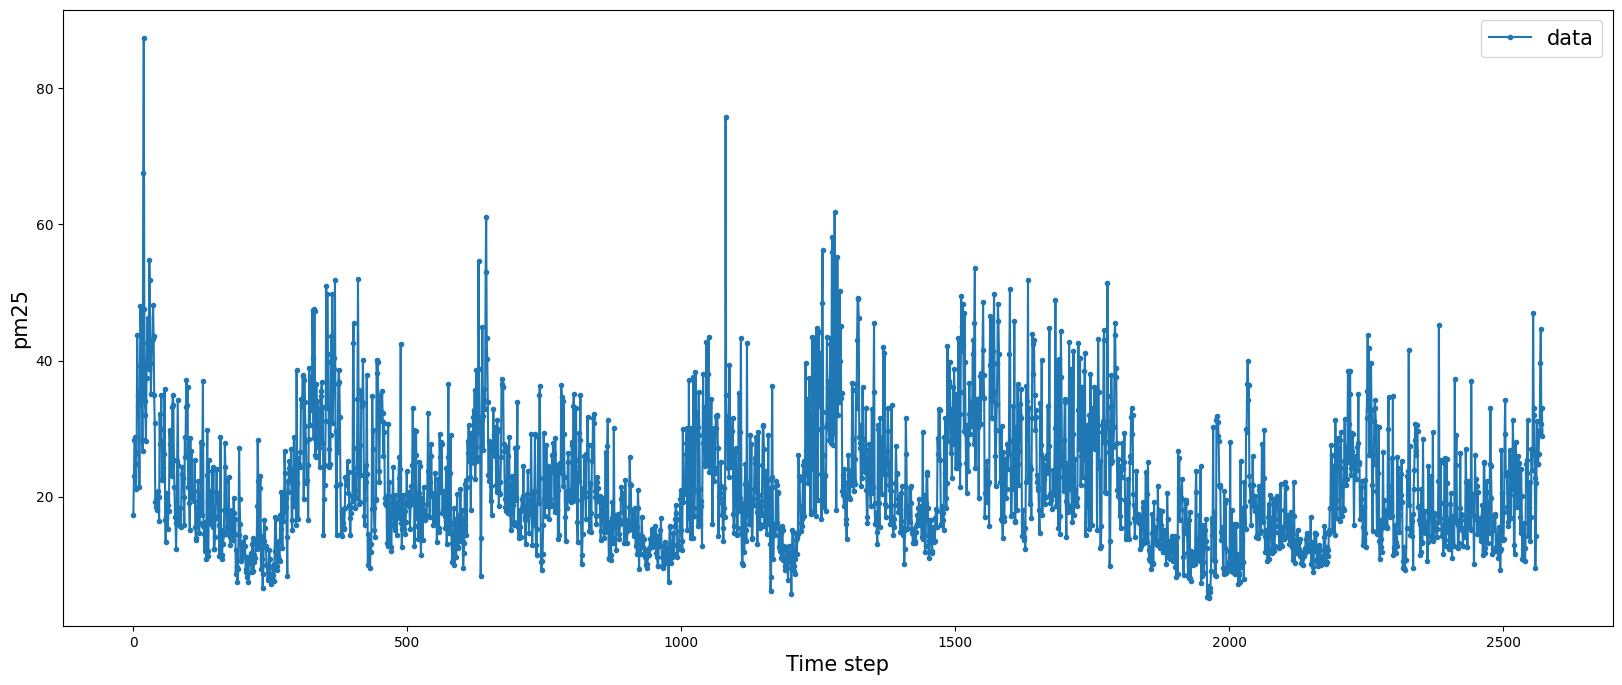

In [21]:
plot_1_data(data=y_aod, datalabel="data", xlabel="Time step", ylabel="pm25")

### Data normalization

In [22]:
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

,lat,lon,station,pop,road_den_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod,pm25_3km,rh,hpbl,wspd,tmp
0,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.175961,0.401465,0.265635,0.382113,0.485894,0.292466
1,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.175961,0.625275,0.257407,0.355779,0.251463,0.259187
2,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.175961,0.628327,0.285912,0.311726,0.161190,0.389039
3,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.175961,0.685226,0.275348,0.423568,0.111222,0.474896
4,0.326794,0.466551,0.0,0.13589,0.599996,0.949821,0.344052,0.00000,0.199903,0.0,0.037975,1.000000,0.0,0.526821,0.175961,0.787668,0.281302,0.461837,0.350381,0.464230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.160199,0.354083,0.567964,0.302546,0.182122,0.125557
2569,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.160199,0.297906,0.377335,0.446013,0.240136,0.289650
2570,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.046031,0.280963,0.412632,0.584396,0.343407,0.289348
2571,0.306899,0.237227,1.0,1.00000,1.000000,0.323578,0.075528,0.62963,0.788964,0.0,0.170886,0.308772,0.0,0.085003,0.160199,0.176000,0.362385,0.473268,0.553589,0.206556


In [23]:
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

,pm25
0,0.147032
1,0.216931
2,0.281258
3,0.287336
4,0.239218
...,...
2568,0.419453
2569,0.480472
2570,0.310835
2571,0.339606


## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25_3km as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [24]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': []}

### Range of dimension

In [25]:
RANGE_OF_DIMENSION = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

13 14 15 16 17 18 19 

### Prediction + LSTM-Seq2Seq

#### Doing the loop

In [26]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
# Apply Seq2seq
    lstms2s = LSTMSeq2SeqReduction(X_aod_scaled,
                               test_percentage=0.2,
                               latent_dim=n,
                               n_past=conf["reduction"]["n_past"], n_future = conf["reduction"]["n_future"],
                               epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                               verbose=0,
                               model_name=f"aod_lstms2s_dim_reduction_{n}_features")
    X_aod_scaled_lstm_s2s_encoded, encoder_model_path = lstms2s.execute()

    lstms2s.get_model_info()
    lstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_lstm_s2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_prediction_with_lstms2s_dim_reduction_{n}_features",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_lstm_s2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

I0000 00:00:1752049911.172310  636939 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0
I0000 00:00:1752049919.374514  637045 service.cc:152] XLA service 0x7420000228e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752049919.374541  637045 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1752049921.344148  637045 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752049923.328408  637045 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "aod_lstms2s_dim_reduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 100)    │     48,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50),      │     30,200 │ lstm[0][0]        │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 13)        │        663 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 7, 13)     │          0 │ dense[0][0]       │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 7, 50)     │     12,800 │ repeat_vector[0]… │
│                     │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 7, 20)     │      2,020 │ lstm_3[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,451 (1.77 MB)

 Trainable params: 154,483 (603.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,968 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,263 (309.62 KB)

 Trainable params: 79,263 (309.62 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 7, 100)    │     48,400 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_6[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 14)        │        714 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 7, 14)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 7, 50)     │     13,000 │ repeat_vector_2[… │
│                     │                   │            │ lstm_7[0][1],     │
│                     │                   │            │ lstm_7[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 7, 20)     │      2,020 │ lstm_9[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,204 (1.77 MB)

 Trainable params: 154,734 (604.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,470 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,314 (309.82 KB)

 Trainable params: 79,314 (309.82 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_12[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 15)        │        765 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 7, 15)     │          0 │ dense_8[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_4[… │
│                     │                   │            │ lstm_13[0][1],    │
│                     │                   │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 7, 20)     │      2,020 │ lstm_15[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,957 (1.77 MB)

 Trainable params: 154,985 (605.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,972 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,365 (310.02 KB)

 Trainable params: 79,365 (310.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_18[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 16)        │        816 │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 7, 16)     │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_6[… │
│                     │                   │            │ lstm_19[0][1],    │
│                     │                   │            │ lstm_19[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_20[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 7, 20)     │      2,020 │ lstm_21[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 465,710 (1.78 MB)

 Trainable params: 155,236 (606.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,474 (1.18 MB)

None


Model: "aod_lstms2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,416 (310.22 KB)

 Trainable params: 79,416 (310.22 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_24[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 17)        │        867 │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 7, 17)     │          0 │ dense_16[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_8[… │
│                     │                   │            │ lstm_25[0][1],    │
│                     │                   │            │ lstm_25[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_26[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 7, 20)     │      2,020 │ lstm_27[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 466,463 (1.78 MB)

 Trainable params: 155,487 (607.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,976 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,467 (310.42 KB)

 Trainable params: 79,467 (310.42 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_30[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 18)        │        918 │ lstm_31[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_10    │ (None, 7, 18)     │          0 │ dense_20[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, 7, 50)     │     13,800 │ repeat_vector_10… │
│                     │                   │            │ lstm_31[0][1],    │
│                     │                   │            │ lstm_31[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_32[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 7, 20)     │      2,020 │ lstm_33[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,216 (1.78 MB)

 Trainable params: 155,738 (608.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 311,478 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,518 (310.62 KB)

 Trainable params: 79,518 (310.62 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_lstms2s_dim_reduction_19_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 7, 100)    │     48,400 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_36[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 19)        │        969 │ lstm_37[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_12    │ (None, 7, 19)     │          0 │ dense_24[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 7, 50)     │     14,000 │ repeat_vector_12… │
│                     │                   │            │ lstm_37[0][1],    │
│                     │                   │            │ lstm_37[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_38[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, 7, 20)     │      2,020 │ lstm_39[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,969 (1.79 MB)

 Trainable params: 155,989 (609.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 311,980 (1.19 MB)

None


Model: "aod_lstms2s_dim_reduction_19_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 7, 100)         │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,569 (310.82 KB)

 Trainable params: 79,569 (310.82 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 13 - MAE = 5.167969601017382
N = 14 - MAE = 4.859298934601529
N = 15 - MAE = 5.003914257942342
N = 16 - MAE = 5.063165304085214
N = 17 - MAE = 5.438786793523143
N = 18 - MAE = 5.01286853965635
N = 19 - MAE = 5.182381982662305


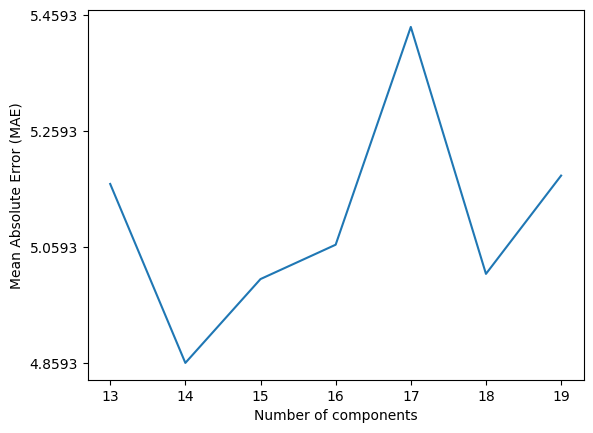

In [27]:
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
best_encoder_model_path = None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


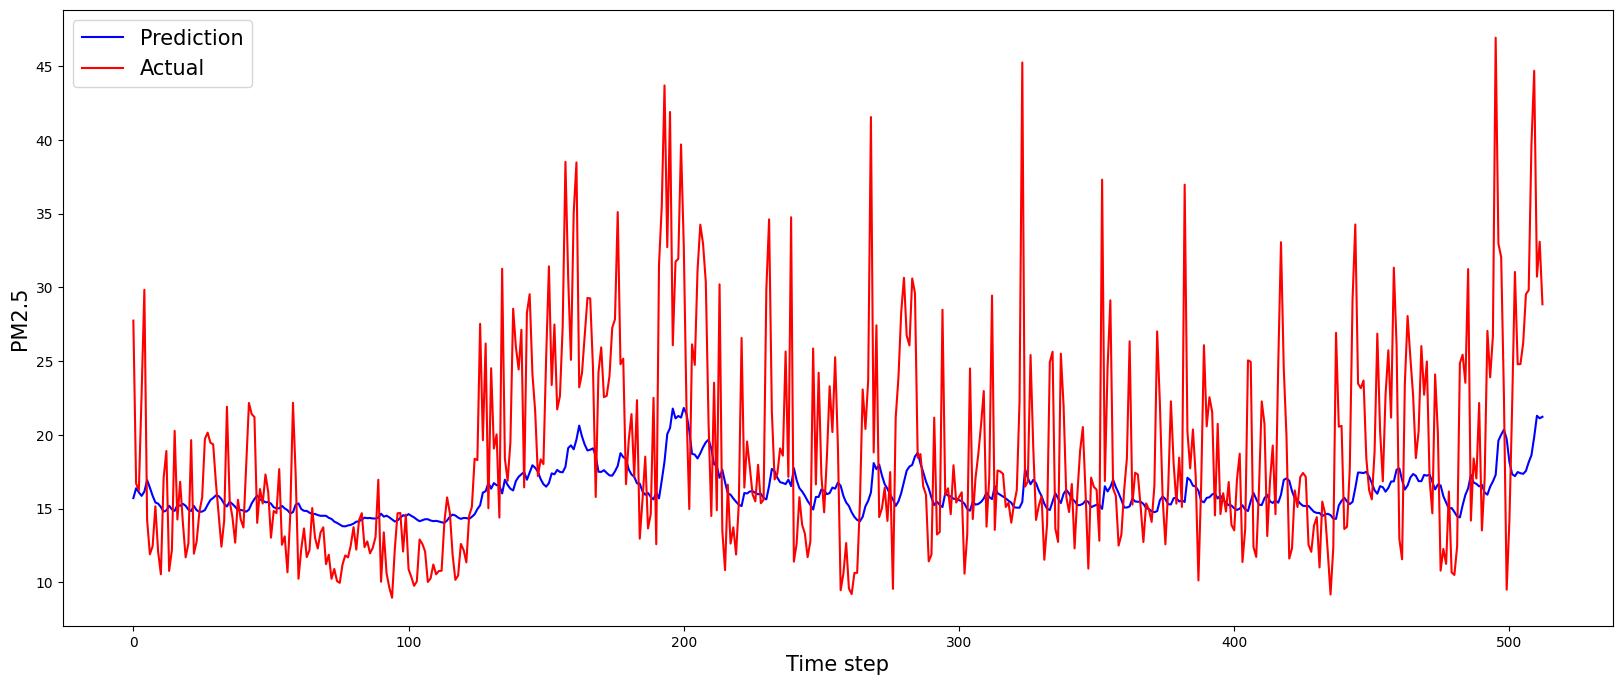

In [28]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

In [29]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

,dim_reduction_method,dim_after_reduction,prediction,mae
0,LSTM-Seq2Seq,14,LSTM,4.859299


#### Prepare reduced data for prediction

In [30]:
best_encoder_model_path

'/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_lstms2s_dim_reduction_14_features_encoder.keras'

In [31]:
df_lstm_s2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstm_s2s_reduced.to_csv("df_lstm_s2s_reduced_2021_2022.csv")
df_lstm_s2s_reduced

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,station
time,,,,,,,,,,,,,,,
2021-01-01,0.331086,-0.007430,-0.507900,0.799533,-0.419325,1.360123,0.312398,-0.379467,0.901661,0.509767,0.424130,-0.540315,-1.080725,-0.989051,201
2021-01-02,0.331086,-0.007430,-0.507900,0.799533,-0.419325,1.360123,0.312398,-0.379467,0.901661,0.509767,0.424130,-0.540315,-1.080725,-0.989051,201
2021-01-03,0.327727,-0.008913,-0.505633,0.800468,-0.418695,1.361996,0.312944,-0.376626,0.899562,0.505444,0.421446,-0.537688,-1.081247,-0.988868,201
2021-01-04,0.325104,-0.011183,-0.502380,0.802114,-0.419535,1.364799,0.315200,-0.373436,0.896407,0.503241,0.420644,-0.535503,-1.081427,-0.989367,201
2021-01-05,0.324128,-0.013405,-0.498169,0.804461,-0.419927,1.368649,0.318811,-0.370726,0.894134,0.503605,0.420879,-0.534637,-1.081886,-0.990121,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.585080,0.912458,0.442821,0.462316,-0.210186,-0.570990,0.890690,-0.323292,0.672763,0.385518,-0.297208,0.042612,-0.221252,-0.536858,216
2022-12-28,0.582652,0.911885,0.440016,0.459972,-0.212199,-0.567268,0.887728,-0.322685,0.668553,0.384679,-0.295537,0.044683,-0.220132,-0.532241,216
2022-12-29,0.580930,0.907312,0.439064,0.454563,-0.210749,-0.564226,0.881136,-0.320117,0.667112,0.373322,-0.293231,0.048934,-0.219782,-0.524880,216


### Prediction + GRU-Seq2Seq

#### Doing the loop

In [32]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    grus2s = GRUSeq2SeqReduction(X_aod_scaled,
                                 test_percentage=0.2,
                                 latent_dim=n,
                                 n_past=conf["reduction"]["n_past"], n_future = conf["reduction"]["n_future"],
                                 epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                 verbose=0,
                                 model_name=f"aod_grus2s_dim_reduction_{n}_features")
    X_aod_scaled_gru_s2s_encoded, encoder_model_path = grus2s.execute()

    grus2s.get_model_info()
    grus2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_gru_s2s_encoded, y_aod_scaled,
                               n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                               epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                               model_name=f"aod_lstm_grus2s_dim_reduction_{n}_features",
                               verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    print(f"N = {n} - MAE = {avg_mae}")
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_gru_s2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Model: "aod_grus2s_dim_reduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 7, 100)    │     36,600 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 50),      │     22,800 │ gru[0][0]         │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 13)        │        663 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 7, 13)     │          0 │ dense_28[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 7, 50)     │      9,750 │ repeat_vector_14… │
│                     │                   │            │ gru_1[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, 7, 20)     │      2,020 │ gru_3[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,301 (1.34 MB)

 Trainable params: 117,433 (458.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,868 (917.46 KB)

None


Model: "aod_grus2s_dim_reduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,063 (234.62 KB)

 Trainable params: 60,063 (234.62 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 13 - MAE = 4.647579439967973


Model: "aod_grus2s_dim_reduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 7, 100)    │     36,600 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 50),      │     22,800 │ gru_4[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 14)        │        714 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_16    │ (None, 7, 14)     │          0 │ dense_32[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 7, 50)     │      9,900 │ repeat_vector_16… │
│                     │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 7, 20)     │      2,020 │ gru_7[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,904 (1.35 MB)

 Trainable params: 117,634 (459.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,270 (919.03 KB)

None


Model: "aod_grus2s_dim_reduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,114 (234.82 KB)

 Trainable params: 60,114 (234.82 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 14 - MAE = 4.451231245954866


Model: "aod_grus2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 7, 100)    │     36,600 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ [(None, 50),      │     22,800 │ gru_8[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 15)        │        765 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_18    │ (None, 7, 15)     │          0 │ dense_36[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_18… │
│                     │                   │            │ gru_9[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 7, 20)     │      2,020 │ gru_11[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,507 (1.35 MB)

 Trainable params: 117,835 (460.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,672 (920.60 KB)

None


Model: "aod_grus2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,165 (235.02 KB)

 Trainable params: 60,165 (235.02 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 15 - MAE = 4.344677151329149


Model: "aod_grus2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 7, 100)    │     36,600 │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, 50),      │     22,800 │ gru_12[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 16)        │        816 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_20    │ (None, 7, 16)     │          0 │ dense_40[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_20… │
│                     │                   │            │ gru_13[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, 7, 20)     │      2,020 │ gru_15[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,110 (1.35 MB)

 Trainable params: 118,036 (461.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,074 (922.17 KB)

None


Model: "aod_grus2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,216 (235.22 KB)

 Trainable params: 60,216 (235.22 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 16 - MAE = 4.8163123910164725


Model: "aod_grus2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 7, 100)    │     36,600 │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ [(None, 50),      │     22,800 │ gru_16[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 17)        │        867 │ gru_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_22    │ (None, 7, 17)     │          0 │ dense_44[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_22… │
│                     │                   │            │ gru_17[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_33 │ (None, 7, 20)     │      2,020 │ gru_19[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,713 (1.35 MB)

 Trainable params: 118,237 (461.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,476 (923.74 KB)

None


Model: "aod_grus2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,267 (235.42 KB)

 Trainable params: 60,267 (235.42 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 17 - MAE = 4.40093907950024


Model: "aod_grus2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_20 (GRU)        │ (None, 7, 100)    │     36,600 │ input_layer_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_21 (GRU)        │ [(None, 50),      │     22,800 │ gru_20[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 18)        │        918 │ gru_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_24    │ (None, 7, 18)     │          0 │ dense_48[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_22 (GRU)        │ (None, 7, 50)     │     10,500 │ repeat_vector_24… │
│                     │                   │            │ gru_21[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_23 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_36 │ (None, 7, 20)     │      2,020 │ gru_23[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 355,316 (1.36 MB)

 Trainable params: 118,438 (462.65 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,878 (925.31 KB)

None


Model: "aod_grus2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,318 (235.62 KB)

 Trainable params: 60,318 (235.62 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 18 - MAE = 4.1990850097982415


Model: "aod_grus2s_dim_reduction_19_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_24 (GRU)        │ (None, 7, 100)    │     36,600 │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_25 (GRU)        │ [(None, 50),      │     22,800 │ gru_24[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 19)        │        969 │ gru_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_26    │ (None, 7, 19)     │          0 │ dense_52[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_26 (GRU)        │ (None, 7, 50)     │     10,650 │ repeat_vector_26… │
│                     │                   │            │ gru_25[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_27 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_39 │ (None, 7, 20)     │      2,020 │ gru_27[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 355,919 (1.36 MB)

 Trainable params: 118,639 (463.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 237,280 (926.88 KB)

None


Model: "aod_grus2s_dim_reduction_19_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 7, 100)         │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,369 (235.82 KB)

 Trainable params: 60,369 (235.82 KB)

 Non-trainable params: 0 (0.00 B)

None
N = 19 - MAE = 4.346459994983933


N = 13 - MAE = 4.647579439967973
N = 14 - MAE = 4.451231245954866
N = 15 - MAE = 4.344677151329149
N = 16 - MAE = 4.8163123910164725
N = 17 - MAE = 4.40093907950024
N = 18 - MAE = 4.1990850097982415
N = 19 - MAE = 4.346459994983933


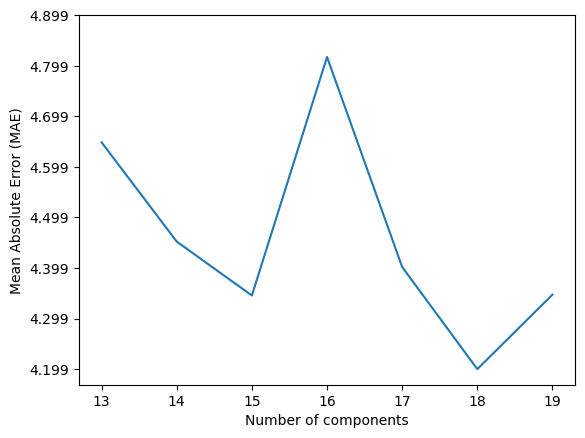

In [33]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.1))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
best_encoder_model_path = None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


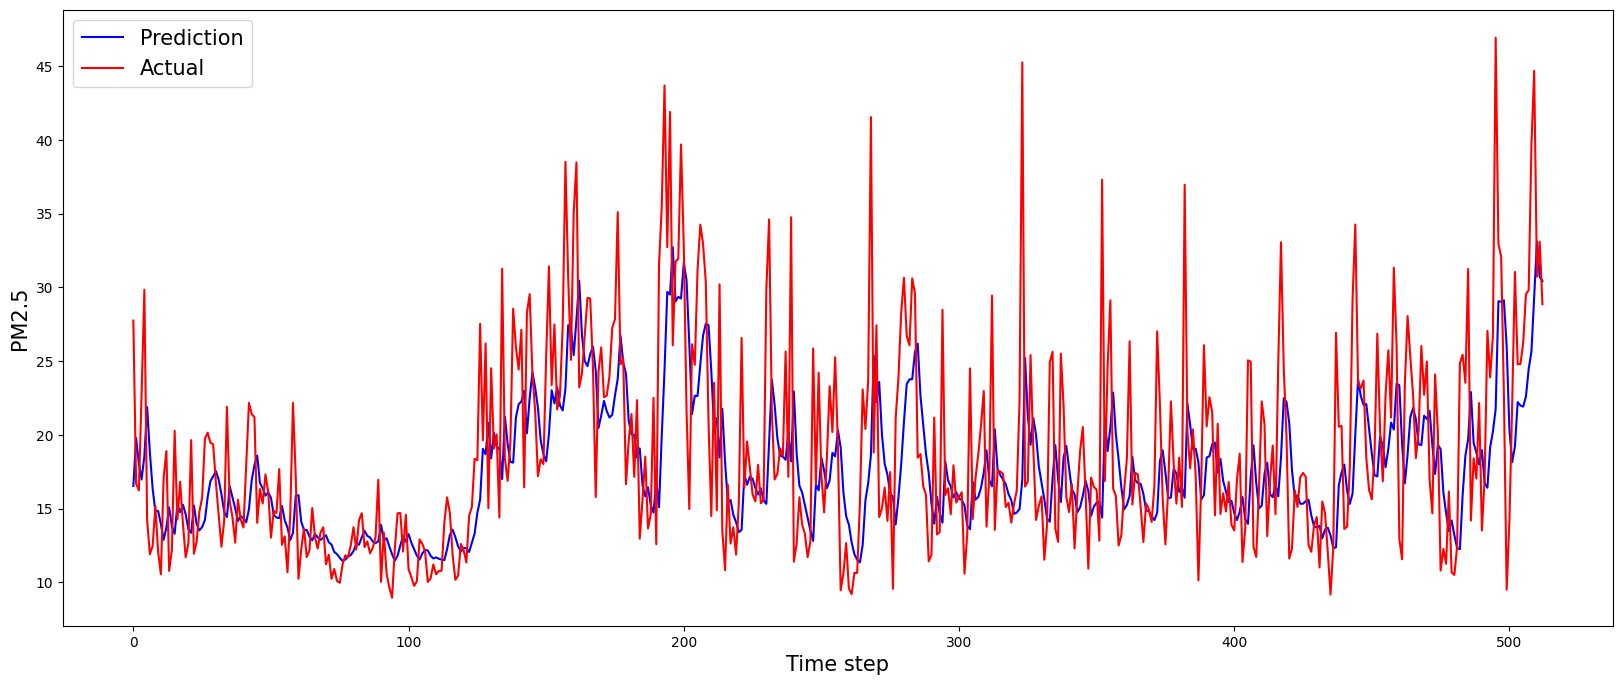

In [34]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
    inv_y_pred = all_days_inv_y_pred[day,:,:]
    inv_y_test = all_days_inv_y_test[day,:,:]
    print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
    plot_2_data(data1=inv_y_pred,
                data2=inv_y_test,
                datalabel1="Prediction",
                datalabel2="Actual",
                xlabel="Time step",
                ylabel="PM2.5")

In [35]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

,dim_reduction_method,dim_after_reduction,prediction,mae
0,LSTM-Seq2Seq,14,LSTM,4.859299
1,GRU-Seq2Seq,18,LSTM,4.199085


#### Prepare reduced data

In [36]:
best_encoder_model_path

'/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_grus2s_dim_reduction_18_features_encoder.keras'

In [37]:
df_gru_s2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_gru_s2s_reduced.to_csv("df_gru_s2s_reduced_2021_2022.csv")
df_gru_s2s_reduced

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,aod_feature_18,station
time,,,,,,,,,,,,,,,,,,,
2021-01-01,0.222759,0.026000,0.013980,0.052304,0.015598,0.089837,0.024145,0.042363,0.077770,0.064119,0.127431,0.026705,0.071149,0.063869,0.017701,0.014625,0.012882,0.036765,201
2021-01-02,0.222759,0.026000,0.013980,0.052304,0.015598,0.089837,0.024145,0.042363,0.077770,0.064119,0.127431,0.026705,0.071149,0.063869,0.017701,0.014625,0.012882,0.036765,201
2021-01-03,0.222162,0.025986,0.014035,0.052200,0.015635,0.089678,0.024210,0.042526,0.078007,0.064347,0.127475,0.026792,0.070947,0.063877,0.017765,0.014672,0.012921,0.036765,201
2021-01-04,0.221916,0.025904,0.014049,0.051996,0.015620,0.089336,0.024268,0.042705,0.078401,0.064711,0.127563,0.026864,0.070602,0.063967,0.017783,0.014674,0.012902,0.036739,201
2021-01-05,0.222531,0.025722,0.013959,0.051686,0.015481,0.088964,0.024238,0.042817,0.078909,0.065081,0.127851,0.026822,0.070215,0.064104,0.017692,0.014554,0.012782,0.036594,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.031548,0.027096,0.059643,0.045659,0.078981,0.038435,0.079539,0.061096,0.038970,0.049277,0.064677,0.081603,0.069702,0.018676,0.031255,0.069762,0.040514,0.113568,216
2022-12-28,0.031689,0.027202,0.059563,0.045927,0.078972,0.038735,0.079346,0.060985,0.039230,0.049436,0.064644,0.081413,0.069678,0.018779,0.031279,0.069581,0.040524,0.113017,216
2022-12-29,0.031656,0.027179,0.059555,0.045832,0.079129,0.038760,0.079347,0.060868,0.039328,0.049452,0.064578,0.081526,0.069605,0.018774,0.031233,0.069622,0.040607,0.112948,216


### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

In [38]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
    # Apply Seq2seq
    cnnlstms2s = CNNLSTMSeq2SeqReduction(X_aod_scaled,
                                        test_percentage=0.2,
                                        latent_dim=n,
                                        n_past=conf["reduction"]["n_past"], n_future=conf["reduction"]["n_future"],
                                        epochs=conf["reduction"]["epochs"], batch_size=conf["reduction"]["batch_size"],
                                        verbose=0,
                                        model_name=f"aod_cnnlstm_s2s_dim_reduction_{n}_features")

    X_aod_scaled_cnnlstm_s2s_encoded, encoder_model_path = cnnlstms2s.execute()

    cnnlstms2s.get_model_info()
    cnnlstms2s.get_encoder_model_info()

    # Prediction
    y_pred, y_test = predictLSTM(X_aod_scaled_cnnlstm_s2s_encoded, y_aod_scaled,
                                n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                                epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                                model_name=f"aod_lstm_cnnlstm_s2s_dim_reduction_{n}_features",
                                verbose=0)

    # Evaluation
    all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, aod_label_scaler, verbose=0)

    # Logging
    loopresults[n]["mae"] = avg_mae
    loopresults[n]["encoded_data"] = X_aod_scaled_cnnlstm_s2s_encoded
    loopresults[n]["encoder_model_path"] = encoder_model_path
    loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

Could not load symbol cuFuncGetName. Error: /lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


Model: "aod_cnnlstm_s2s_dim_reduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 24)     │      1,464 │ input_layer_42[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 12)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12)        │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_28    │ (None, 7, 12)     │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_56 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_28… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 13)        │        663 │ lstm_56[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_29    │ (None, 7, 13)     │          0 │ dense_56[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_57 (LSTM)      │ (None, 7, 50)     │     12,800 │ repeat_vector_29… │
│                     │                   │            │ lstm_56[0][1],    │
│                     │                   │            │ lstm_56[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_42 │ (None, 7, 24)     │      1,224 │ lstm_57[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_43 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 90,383 (353.06 KB)

 Trainable params: 30,127 (117.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,256 (235.38 KB)

None


Model: "aod_cnnlstm_s2s_dim_reduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_28 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,603 (60.95 KB)

 Trainable params: 15,603 (60.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstm_s2s_dim_reduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5, 24)     │      1,464 │ input_layer_45[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1, 12)     │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_31    │ (None, 7, 12)     │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_60 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_31… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 14)        │        714 │ lstm_60[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_32    │ (None, 7, 14)     │          0 │ dense_61[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_61 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_32… │
│                     │                   │            │ lstm_60[0][1],    │
│                     │                   │            │ lstm_60[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_46 │ (None, 7, 24)     │      1,224 │ lstm_61[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_47 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,136 (356.00 KB)

 Trainable params: 30,378 (118.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,758 (237.34 KB)

None


Model: "aod_cnnlstm_s2s_dim_reduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_31 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,654 (61.15 KB)

 Trainable params: 15,654 (61.15 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstm_s2s_dim_reduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5, 24)     │      1,464 │ input_layer_48[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1, 12)     │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_34    │ (None, 7, 12)     │          0 │ flatten_2[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_64 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_34… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 15)        │        765 │ lstm_64[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_35    │ (None, 7, 15)     │          0 │ dense_66[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_65 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_35… │
│                     │                   │            │ lstm_64[0][1],    │
│                     │                   │            │ lstm_64[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_50 │ (None, 7, 24)     │      1,224 │ lstm_65[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_51 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,889 (358.95 KB)

 Trainable params: 30,629 (119.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,260 (239.30 KB)

None


Model: "aod_cnnlstm_s2s_dim_reduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_34 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,705 (61.35 KB)

 Trainable params: 15,705 (61.35 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstm_s2s_dim_reduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5, 24)     │      1,464 │ input_layer_51[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1, 12)     │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_37    │ (None, 7, 12)     │          0 │ flatten_3[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_68 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_37… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 16)        │        816 │ lstm_68[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_38    │ (None, 7, 16)     │          0 │ dense_71[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_69 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_38… │
│                     │                   │            │ lstm_68[0][1],    │
│                     │                   │            │ lstm_68[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_54 │ (None, 7, 24)     │      1,224 │ lstm_69[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_55 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,642 (361.89 KB)

 Trainable params: 30,880 (120.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,762 (241.26 KB)

None


Model: "aod_cnnlstm_s2s_dim_reduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_37 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,756 (61.55 KB)

 Trainable params: 15,756 (61.55 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstm_s2s_dim_reduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_54      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 5, 24)     │      1,464 │ input_layer_54[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 1, 12)     │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_40    │ (None, 7, 12)     │          0 │ flatten_4[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_72 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_40… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 17)        │        867 │ lstm_72[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_41    │ (None, 7, 17)     │          0 │ dense_76[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_73 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_41… │
│                     │                   │            │ lstm_72[0][1],    │
│                     │                   │            │ lstm_72[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_58 │ (None, 7, 24)     │      1,224 │ lstm_73[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_59 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,395 (364.83 KB)

 Trainable params: 31,131 (121.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,264 (243.22 KB)

None


Model: "aod_cnnlstm_s2s_dim_reduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_40 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_72 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,807 (61.75 KB)

 Trainable params: 15,807 (61.75 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstm_s2s_dim_reduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_57      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 5, 24)     │      1,464 │ input_layer_57[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 1, 12)     │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_43    │ (None, 7, 12)     │          0 │ flatten_5[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_76 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_43… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 18)        │        918 │ lstm_76[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_44    │ (None, 7, 18)     │          0 │ dense_81[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_77 (LSTM)      │ (None, 7, 50)     │     13,800 │ repeat_vector_44… │
│                     │                   │            │ lstm_76[0][1],    │
│                     │                   │            │ lstm_76[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_62 │ (None, 7, 24)     │      1,224 │ lstm_77[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_63 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 94,148 (367.77 KB)

 Trainable params: 31,382 (122.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,766 (245.18 KB)

None


Model: "aod_cnnlstm_s2s_dim_reduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_43 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,858 (61.95 KB)

 Trainable params: 15,858 (61.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_cnnlstm_s2s_dim_reduction_19_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60      │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 5, 24)     │      1,464 │ input_layer_60[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1, 12)     │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_46    │ (None, 7, 12)     │          0 │ flatten_6[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_80 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_46… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 19)        │        969 │ lstm_80[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_47    │ (None, 7, 19)     │          0 │ dense_86[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_81 (LSTM)      │ (None, 7, 50)     │     14,000 │ repeat_vector_47… │
│                     │                   │            │ lstm_80[0][1],    │
│                     │                   │            │ lstm_80[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_66 │ (None, 7, 24)     │      1,224 │ lstm_81[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_67 │ (None, 7, 20)     │        500 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 94,901 (370.71 KB)

 Trainable params: 31,633 (123.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,268 (247.14 KB)

None


Model: "aod_cnnlstm_s2s_dim_reduction_19_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_61 (InputLayer)     │ (None, 7, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 5, 24)          │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_46 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 19)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,909 (62.14 KB)

 Trainable params: 15,909 (62.14 KB)

 Non-trainable params: 0 (0.00 B)

None


N = 13 - MAE = 5.161861055277072
N = 14 - MAE = 4.383670772138943
N = 15 - MAE = 4.874600113608725
N = 16 - MAE = 4.992491854367264
N = 17 - MAE = 5.2959540064020665
N = 18 - MAE = 4.698769383576573
N = 19 - MAE = 4.69817770836047


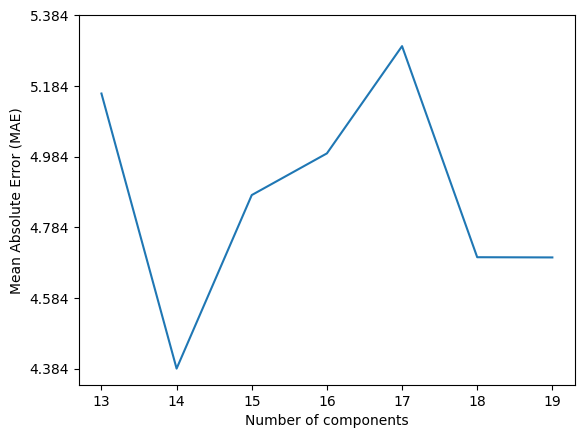

In [39]:
for n in loopresults.keys():
    print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
best_encoder_model_path = None
for n in loopresults.keys():
    if loopresults[n]["mae"] < best_mae:
        best_num_of_components = n
        best_mae = loopresults[n]["mae"]
        best_encoded_data = loopresults[n]["encoded_data"]
        best_evaluation_data = loopresults[n]["evaluation_data"]
        best_encoder_model_path = loopresults[n]["encoder_model_path"]

evaluation_board['dim_reduction_method'] += ["CNN-LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


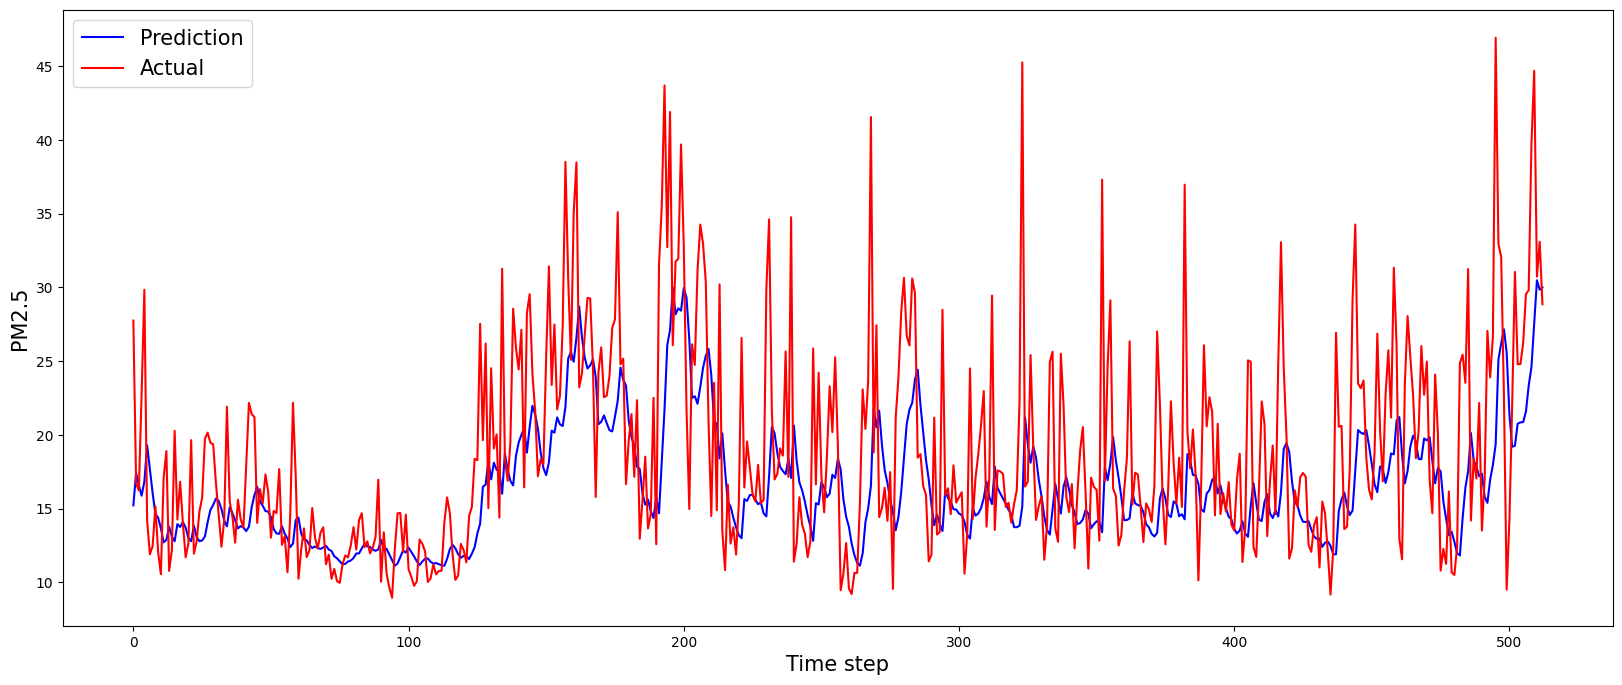

In [40]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(conf["prediction"]["n_future"]):
  inv_y_pred = all_days_inv_y_pred[day,:,:]
  inv_y_test = all_days_inv_y_test[day,:,:]
  print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
  plot_2_data(data1=inv_y_pred,
              data2=inv_y_test,
              datalabel1="Prediction",
              datalabel2="Actual",
              xlabel="Time step",
              ylabel="PM2.5")

In [41]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

,dim_reduction_method,dim_after_reduction,prediction,mae
0,LSTM-Seq2Seq,14,LSTM,4.859299
1,GRU-Seq2Seq,18,LSTM,4.199085
2,CNN-LSTM-Seq2Seq,14,LSTM,4.383671


#### Prepare reduced data

In [42]:
best_encoder_model_path

'/le_thanh_van_118/workspace/hiep_workspace/model_info/aod_cnnlstm_s2s_dim_reduction_14_features_encoder.keras'

In [43]:
df_cnnlstm_s2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstm_s2s_reduced.to_csv("df_cnnlstm_s2s_reduced_2021_2022.csv")
df_cnnlstm_s2s_reduced

,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,station
time,,,,,,,,,,,,,,,
2021-01-01,-0.067653,0.041451,-0.054687,-0.099870,-0.309918,0.122150,0.374627,0.476770,0.150436,-0.185525,0.327488,0.166819,-0.176019,-0.818028,201
2021-01-02,-0.067653,0.041451,-0.054687,-0.099870,-0.309918,0.122150,0.374627,0.476770,0.150436,-0.185525,0.327488,0.166819,-0.176019,-0.818028,201
2021-01-03,-0.067653,0.041451,-0.054687,-0.099870,-0.309918,0.122150,0.374627,0.476770,0.150436,-0.185525,0.327488,0.166819,-0.176019,-0.818028,201
2021-01-04,-0.068637,0.040160,-0.055249,-0.099766,-0.309032,0.122406,0.372278,0.476518,0.151249,-0.185385,0.327399,0.167663,-0.175124,-0.817408,201
2021-01-05,-0.069448,0.040452,-0.054436,-0.099380,-0.308389,0.123083,0.367681,0.473335,0.148585,-0.182037,0.328419,0.164676,-0.170539,-0.812488,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-0.103621,-0.126313,-0.044054,-0.260410,0.074204,0.562387,-0.102464,0.086067,0.121486,-0.526587,0.087901,-0.040529,-0.169241,-0.550095,216
2022-12-28,-0.107027,-0.121562,-0.041067,-0.259511,0.061204,0.551145,-0.105409,0.088267,0.119930,-0.514627,0.089788,-0.032678,-0.161961,-0.535215,216
2022-12-29,-0.100826,-0.124236,-0.044181,-0.255932,0.062202,0.550145,-0.101618,0.090445,0.121341,-0.515707,0.088754,-0.032315,-0.163335,-0.543326,216


## Compare the score

In [44]:
y_aod_scaled

,pm25
0,0.147032
1,0.216931
2,0.281258
3,0.287336
4,0.239218
...,...
2568,0.419453
2569,0.480472
2570,0.310835
2571,0.339606


### LSTM-Seq2Seq

In [45]:
print(df_lstm_s2s_reduced.shape)
df_lstm_s2s_reduced

(2573, 15)


,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,station
time,,,,,,,,,,,,,,,
2021-01-01,0.331086,-0.007430,-0.507900,0.799533,-0.419325,1.360123,0.312398,-0.379467,0.901661,0.509767,0.424130,-0.540315,-1.080725,-0.989051,201
2021-01-02,0.331086,-0.007430,-0.507900,0.799533,-0.419325,1.360123,0.312398,-0.379467,0.901661,0.509767,0.424130,-0.540315,-1.080725,-0.989051,201
2021-01-03,0.327727,-0.008913,-0.505633,0.800468,-0.418695,1.361996,0.312944,-0.376626,0.899562,0.505444,0.421446,-0.537688,-1.081247,-0.988868,201
2021-01-04,0.325104,-0.011183,-0.502380,0.802114,-0.419535,1.364799,0.315200,-0.373436,0.896407,0.503241,0.420644,-0.535503,-1.081427,-0.989367,201
2021-01-05,0.324128,-0.013405,-0.498169,0.804461,-0.419927,1.368649,0.318811,-0.370726,0.894134,0.503605,0.420879,-0.534637,-1.081886,-0.990121,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.585080,0.912458,0.442821,0.462316,-0.210186,-0.570990,0.890690,-0.323292,0.672763,0.385518,-0.297208,0.042612,-0.221252,-0.536858,216
2022-12-28,0.582652,0.911885,0.440016,0.459972,-0.212199,-0.567268,0.887728,-0.322685,0.668553,0.384679,-0.295537,0.044683,-0.220132,-0.532241,216
2022-12-29,0.580930,0.907312,0.439064,0.454563,-0.210749,-0.564226,0.881136,-0.320117,0.667112,0.373322,-0.293231,0.048934,-0.219782,-0.524880,216


In [46]:
y_pred = predictLSTMNoSplit(df_lstm_s2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_lstm_s2s_lstm_predict_no_split",
                           verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


In [47]:
print(y_pred.shape)
y_pred

(2573, 1, 1)


array([[[0.16878206]],

       [[0.16878206]],

       [[0.17644812]],

       ...,

       [[0.23091571]],

       [[0.22646609]],

       [[0.22748628]]], dtype=float32)

In [48]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

,0
0,0.168782
1,0.168782
2,0.176448
3,0.189318
4,0.199798
...,...
2568,0.186129
2569,0.207919
2570,0.230916
2571,0.226466


In [49]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

array([[17.25      ],
       [23.        ],
       [28.29166667],
       ...,
       [30.7247081 ],
       [33.09142799],
       [28.85406871]])

In [50]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

array([[19.039179],
       [19.039179],
       [19.669802],
       ...,
       [24.150404],
       [23.78437 ],
       [23.868294]], dtype=float32)

In [51]:
mean_absolute_error(inv_y_aod, inv_y_pred)

5.657079570842988

In [52]:
mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"])

7.768970258629239

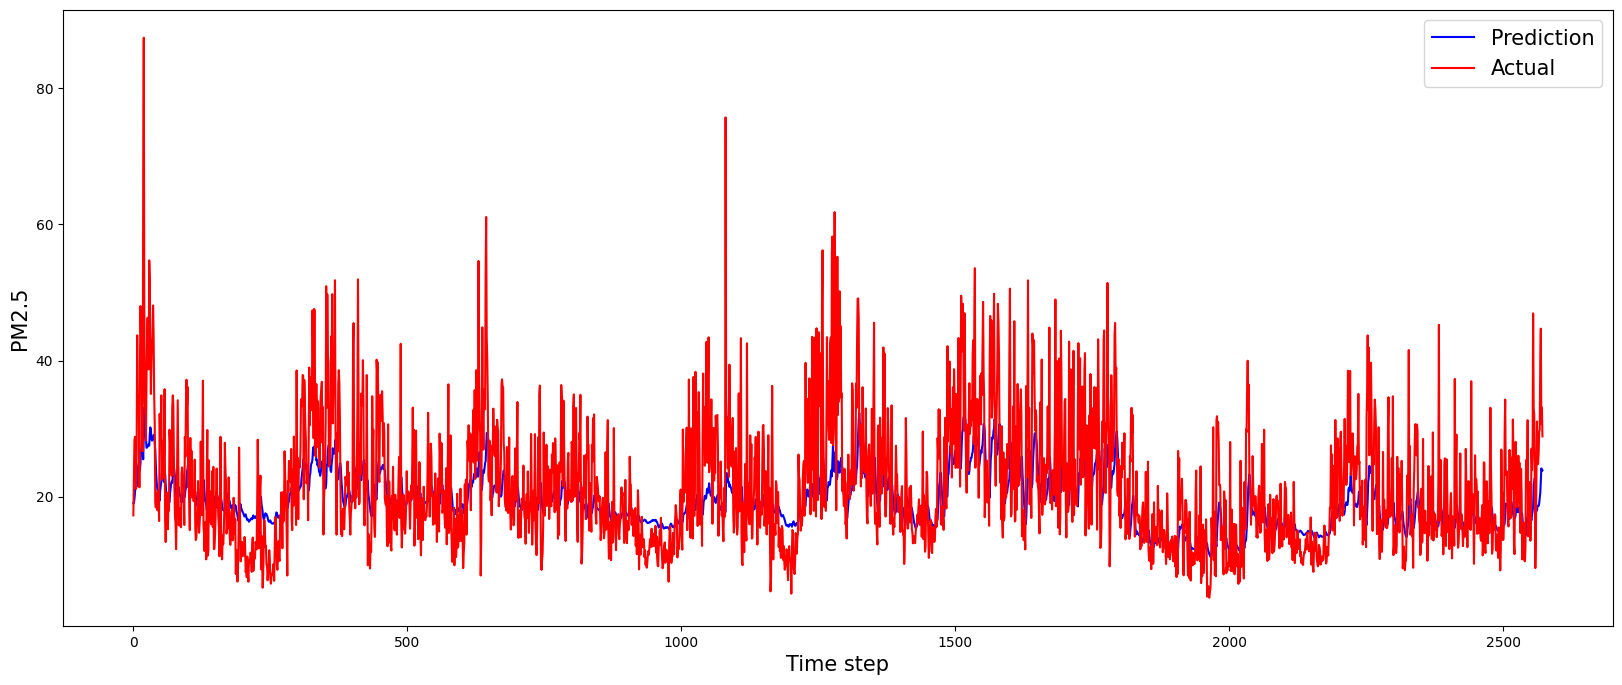

In [53]:
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")

### GRU-Seq2Seq

In [54]:
print(df_gru_s2s_reduced.shape)
df_gru_s2s_reduced

(2573, 19)


,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,aod_feature_15,aod_feature_16,aod_feature_17,aod_feature_18,station
time,,,,,,,,,,,,,,,,,,,
2021-01-01,0.222759,0.026000,0.013980,0.052304,0.015598,0.089837,0.024145,0.042363,0.077770,0.064119,0.127431,0.026705,0.071149,0.063869,0.017701,0.014625,0.012882,0.036765,201
2021-01-02,0.222759,0.026000,0.013980,0.052304,0.015598,0.089837,0.024145,0.042363,0.077770,0.064119,0.127431,0.026705,0.071149,0.063869,0.017701,0.014625,0.012882,0.036765,201
2021-01-03,0.222162,0.025986,0.014035,0.052200,0.015635,0.089678,0.024210,0.042526,0.078007,0.064347,0.127475,0.026792,0.070947,0.063877,0.017765,0.014672,0.012921,0.036765,201
2021-01-04,0.221916,0.025904,0.014049,0.051996,0.015620,0.089336,0.024268,0.042705,0.078401,0.064711,0.127563,0.026864,0.070602,0.063967,0.017783,0.014674,0.012902,0.036739,201
2021-01-05,0.222531,0.025722,0.013959,0.051686,0.015481,0.088964,0.024238,0.042817,0.078909,0.065081,0.127851,0.026822,0.070215,0.064104,0.017692,0.014554,0.012782,0.036594,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.031548,0.027096,0.059643,0.045659,0.078981,0.038435,0.079539,0.061096,0.038970,0.049277,0.064677,0.081603,0.069702,0.018676,0.031255,0.069762,0.040514,0.113568,216
2022-12-28,0.031689,0.027202,0.059563,0.045927,0.078972,0.038735,0.079346,0.060985,0.039230,0.049436,0.064644,0.081413,0.069678,0.018779,0.031279,0.069581,0.040524,0.113017,216
2022-12-29,0.031656,0.027179,0.059555,0.045832,0.079129,0.038760,0.079347,0.060868,0.039328,0.049452,0.064578,0.081526,0.069605,0.018774,0.031233,0.069622,0.040607,0.112948,216


In [55]:
y_pred = predictLSTMNoSplit(df_gru_s2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_gru_s2s_lstm_predict_no_split",
                           verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


In [56]:
print(y_pred.shape)
y_pred

(2573, 1, 1)


array([[[0.15427619]],

       [[0.15427619]],

       [[0.17690949]],

       ...,

       [[0.3422154 ]],

       [[0.31184986]],

       [[0.30550614]]], dtype=float32)

In [57]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

,0
0,0.154276
1,0.154276
2,0.176909
3,0.212246
4,0.235478
...,...
2568,0.247590
2569,0.294737
2570,0.342215
2571,0.311850


In [58]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

array([[17.25      ],
       [23.        ],
       [28.29166667],
       ...,
       [30.7247081 ],
       [33.09142799],
       [28.85406871]])

In [59]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

array([[17.8459  ],
       [17.8459  ],
       [19.707756],
       ...,
       [33.306118],
       [30.808193],
       [30.286348]], dtype=float32)

In [60]:
mean_absolute_error(inv_y_aod, inv_y_pred)

5.035344825405239

In [61]:
mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"])

7.768970258629239

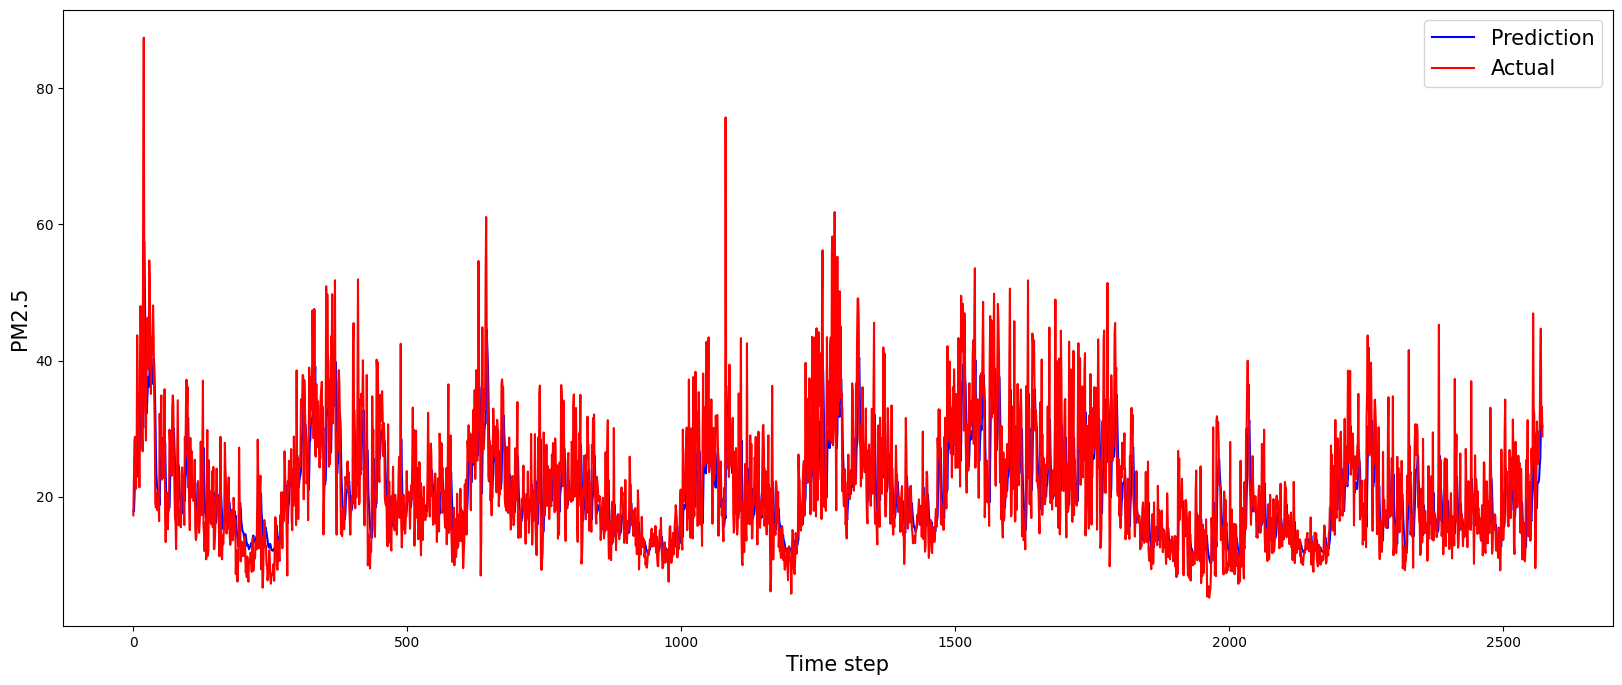

In [62]:
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")

### CNNLSTM-Seq2Seq

In [63]:
print(df_cnnlstm_s2s_reduced.shape)
df_cnnlstm_s2s_reduced

(2573, 15)


,aod_feature_1,aod_feature_2,aod_feature_3,aod_feature_4,aod_feature_5,aod_feature_6,aod_feature_7,aod_feature_8,aod_feature_9,aod_feature_10,aod_feature_11,aod_feature_12,aod_feature_13,aod_feature_14,station
time,,,,,,,,,,,,,,,
2021-01-01,-0.067653,0.041451,-0.054687,-0.099870,-0.309918,0.122150,0.374627,0.476770,0.150436,-0.185525,0.327488,0.166819,-0.176019,-0.818028,201
2021-01-02,-0.067653,0.041451,-0.054687,-0.099870,-0.309918,0.122150,0.374627,0.476770,0.150436,-0.185525,0.327488,0.166819,-0.176019,-0.818028,201
2021-01-03,-0.067653,0.041451,-0.054687,-0.099870,-0.309918,0.122150,0.374627,0.476770,0.150436,-0.185525,0.327488,0.166819,-0.176019,-0.818028,201
2021-01-04,-0.068637,0.040160,-0.055249,-0.099766,-0.309032,0.122406,0.372278,0.476518,0.151249,-0.185385,0.327399,0.167663,-0.175124,-0.817408,201
2021-01-05,-0.069448,0.040452,-0.054436,-0.099380,-0.308389,0.123083,0.367681,0.473335,0.148585,-0.182037,0.328419,0.164676,-0.170539,-0.812488,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-0.103621,-0.126313,-0.044054,-0.260410,0.074204,0.562387,-0.102464,0.086067,0.121486,-0.526587,0.087901,-0.040529,-0.169241,-0.550095,216
2022-12-28,-0.107027,-0.121562,-0.041067,-0.259511,0.061204,0.551145,-0.105409,0.088267,0.119930,-0.514627,0.089788,-0.032678,-0.161961,-0.535215,216
2022-12-29,-0.100826,-0.124236,-0.044181,-0.255932,0.062202,0.550145,-0.101618,0.090445,0.121341,-0.515707,0.088754,-0.032315,-0.163335,-0.543326,216


In [64]:
y_pred = predictLSTMNoSplit(df_cnnlstm_s2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_cnnlstm_s2s_lstm_predict_no_split",
                           verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


In [65]:
print(y_pred.shape)
y_pred

(2573, 1, 1)


array([[[0.12185397]],

       [[0.12185397]],

       [[0.13754536]],

       ...,

       [[0.3073986 ]],

       [[0.29560423]],

       [[0.29441032]]], dtype=float32)

In [66]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

,0
0,0.121854
1,0.121854
2,0.137545
3,0.163806
4,0.184472
...,...
2568,0.237240
2569,0.272322
2570,0.307399
2571,0.295604


In [67]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

array([[17.25      ],
       [23.        ],
       [28.29166667],
       ...,
       [30.7247081 ],
       [33.09142799],
       [28.85406871]])

In [68]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

array([[15.178788],
       [15.178788],
       [16.469591],
       ...,
       [30.442024],
       [29.4718  ],
       [29.373585]], dtype=float32)

In [69]:
mean_absolute_error(inv_y_aod, inv_y_pred)

5.457136607490312

In [70]:
mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"])

7.768970258629239

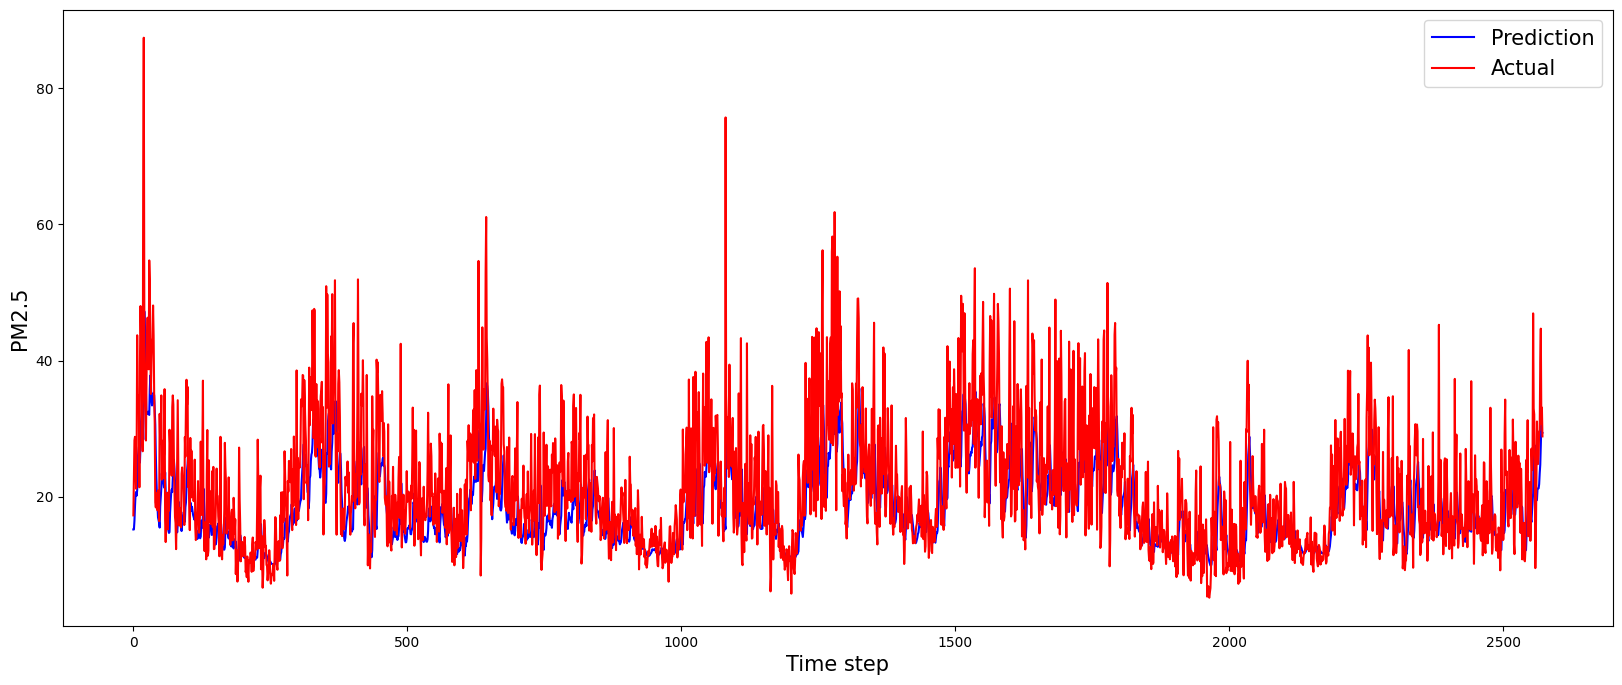

In [71]:
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")

In [72]:
best_encoded_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.067653,0.041451,-0.054687,-0.099870,-0.309918,0.122150,0.374627,0.476770,0.150436,-0.185525,0.327488,0.166819,-0.176019,-0.818028
1,-0.067653,0.041451,-0.054687,-0.099870,-0.309918,0.122150,0.374627,0.476770,0.150436,-0.185525,0.327488,0.166819,-0.176019,-0.818028
2,-0.067653,0.041451,-0.054687,-0.099870,-0.309918,0.122150,0.374627,0.476770,0.150436,-0.185525,0.327488,0.166819,-0.176019,-0.818028
3,-0.068637,0.040160,-0.055249,-0.099766,-0.309032,0.122406,0.372278,0.476518,0.151249,-0.185385,0.327399,0.167663,-0.175124,-0.817408
4,-0.069448,0.040452,-0.054436,-0.099380,-0.308389,0.123083,0.367681,0.473335,0.148585,-0.182037,0.328419,0.164676,-0.170539,-0.812488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,-0.103621,-0.126313,-0.044054,-0.260410,0.074204,0.562387,-0.102464,0.086067,0.121486,-0.526587,0.087901,-0.040529,-0.169241,-0.550095
2569,-0.107027,-0.121562,-0.041067,-0.259511,0.061204,0.551145,-0.105409,0.088267,0.119930,-0.514627,0.089788,-0.032678,-0.161961,-0.535215
2570,-0.100826,-0.124236,-0.044181,-0.255932,0.062202,0.550145,-0.101618,0.090445,0.121341,-0.515707,0.088754,-0.032315,-0.163335,-0.543326
2571,-0.098800,-0.124095,-0.043662,-0.256190,0.062321,0.551927,-0.098068,0.089554,0.123192,-0.517403,0.087865,-0.030246,-0.168663,-0.543554
